## Text Analytics using NLP - Stan Lee (Web Scrapping - Twitter)

*Richard Abraham*

Using Twitter's streaming API to extract the relevant tweets

In [ ]:
# Import the necessary methods from tweepy library
import tweepy
from tweepy.streaming import StreamListener
from tweepy import OAuthHandler
from tweepy import Stream

# Variables that contain the user credentials to access the Twitter API 
access_token = "1058460595823898624-......."
access_token_secret = "1WEXnY90QqgojwwjWyHIx-.......""
consumer_key = "hjyl9h70XUVH2-.......""
consumer_secret = "UPdbm6nMcgqPSXifM7wer-.......""


# This is a basic listener that just prints received tweets to stdout
class StdOutListener(StreamListener):

    def on_data(self, data):
        file=open('C:/Users/Admin/Desktop/NLP Project/twitter_data.txt','a')
        file.write(data)
        file.close()
        #print(data) #prints output on screen if required
        return True
    
    def on_error(self, status):
        print(status)


if __name__ == '__main__':

    # This handles Twitter authetication and the connection to Twitter's Streaming API
    l = StdOutListener()
    auth = OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_token, access_token_secret)
    stream = Stream(auth, l)
   

    # This line filters Twitter Streams to capture data by the keywords: 'Stan Lee','StanLee','Stanley Martin Lieber'
    stream.filter(track=['Stan Lee','StanLee','Stanley Martin Lieber'])
    

#### The code above allows me to only extract live tweets as they are generated

### To extract historical tweets, view the python file named 'historical_tweets_extraction_py.ipynb'
* Please note Twitter limits the maximum age of searchable tweets to roughly a week. As such, the script can search for tweets posted up to just over a week ago.

Proceeding with the live tweets collection...

In [3]:
# Importing other packages

import re
from textblob import TextBlob as tb
import json
import numpy as np
import pandas as pd
from IPython.display import display
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
matplotlib.style.use('ggplot')
%matplotlib inline
import datetime

In [4]:
# Reading and storing the data into a dataframe
tweets_data_path = 'C:/Users/Admin/Desktop/NLP Project/twitter_data.txt'

tweets_data = []
tweets_file = open(tweets_data_path, "r")
for line in tweets_file:
    try:
        tweet = json.loads(line)
        tweets_data.append(tweet)
    except:
        continue

Loaded approximately ~50,000 tweets

In [6]:
#Example of a tweet in JSON format
tweets_data[0:1]

[{'created_at': 'Fri Nov 23 17:19:17 +0000 2018',
  'id': 1066018360801013760,
  'id_str': '1066018360801013760',
  'text': 'RT @heroinitiative: Stan Lee was, of course, a great friend of Hero Initiative. But more broadly and more importantly, he was a great frien…',
  'source': '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
  'truncated': False,
  'in_reply_to_status_id': None,
  'in_reply_to_status_id_str': None,
  'in_reply_to_user_id': None,
  'in_reply_to_user_id_str': None,
  'in_reply_to_screen_name': None,
  'user': {'id': 618419414,
   'id_str': '618419414',
   'name': 'Jake Roundtree',
   'screen_name': 'JacobRoundtree',
   'location': 'kentucky',
   'url': None,
   'description': None,
   'translator_type': 'none',
   'protected': False,
   'verified': False,
   'followers_count': 293,
   'friends_count': 579,
   'listed_count': 0,
   'favourites_count': 766,
   'statuses_count': 630,
   'created_at': 'Mon Jun 25 20:44:44 +0000 2012',
 

In [7]:
#Creating an empty data frame
tweets = pd.DataFrame()

In [8]:
# Adding columns for entities that will later be used for the analysis

tweets['text'] = list(map(lambda tweet: tweet['text'], tweets_data))
tweets['lang'] = list(map(lambda tweet: tweet['lang'], tweets_data))
tweets['word_count'] = tweets['text'].apply(lambda x: len(str(x).split(" "))) #derived field
tweets['Location'] = list(map(lambda tweet: tweet['user']['location'], tweets_data))
tweets['country'] = list(map(lambda tweet: tweet['place']['country'] if tweet['place'] != None else None, tweets_data))

In [9]:
# Getting other relevant information from the tweets

tweets['id'] = list(map(lambda tweet: tweet['id'], tweets_data))
tweets['created_at'] = list(map(lambda tweet: tweet['created_at'], tweets_data))
tweets['Source'] = list(map(lambda tweet: tweet['source'], tweets_data))
tweets['Likes'] = list(map(lambda tweet: tweet['user']['favourites_count'], tweets_data))

In [10]:
# Retweets - True / False - Adding column to show if retweeted
RT = []
for t in tweets.text:
    RT.append(t.split()[0]=='RT')
tweets['RT'] = RT

In [11]:
tweets.head(3)

,text,lang,word_count,Location,country,id,created_at,Source,Likes,RT
0,"RT @heroinitiative: Stan Lee was, of course, a...",en,24,kentucky,None,1066018360801013760,Fri Nov 23 17:19:17 +0000 2018,"<a href=""http://twitter.com/download/iphone"" r...",766,True
1,RT @shawnwarner629: A Stan Lee memorial mural ...,en,25,"Queens, NYC",None,1066018372419272704,Fri Nov 23 17:19:20 +0000 2018,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",31826,True
2,#Marvel Studios chief Kevin Feige describes hi...,en,13,None,None,1066018398864375808,Fri Nov 23 17:19:26 +0000 2018,"<a href=""http://twicca.r246.jp/"" rel=""nofollow...",0,False


In [12]:
# Converting to datetime for Time Series analysis
tweets['created_at'] = pd.to_datetime(tweets['created_at'])

### EXPLORATORY DATA ANALYSIS

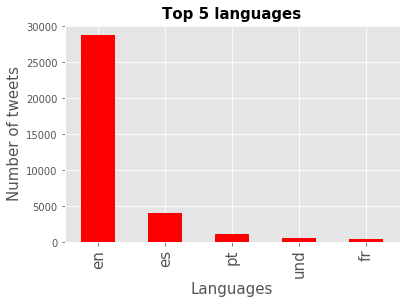

In [14]:
# Top 5 languages used
tweets_by_lang = tweets['lang'].value_counts()

fig, ax = plt.subplots()
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=10)
ax.set_xlabel('Languages', fontsize=15)
ax.set_ylabel('Number of tweets' , fontsize=15)
ax.set_title('Top 5 languages', fontsize=15, fontweight='bold')
tweets_by_lang[:5].plot(ax=ax, kind='bar', color='red')

- English seems to be the most commonly used language followed by Spanish

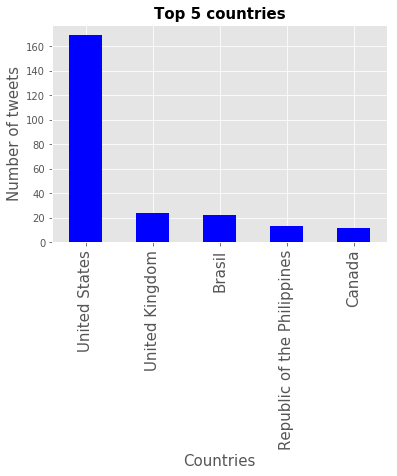

In [15]:
# Top 5 countries
tweets_by_country = tweets['country'].value_counts()

fig, ax = plt.subplots()
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=10)
ax.set_xlabel('Countries', fontsize=15)
ax.set_ylabel('Number of tweets' , fontsize=15)
ax.set_title('Top 5 countries', fontsize=15, fontweight='bold')
tweets_by_country[:5].plot(ax=ax, kind='bar', color='blue')

In [13]:
# Getting the average word count of tweets
tweets['word_count'].mean()

17.96304276674667

- ~18 words per tweet on average

**[Using Textblob Sentiment to calculate polarity and subjectivity of tweets](https://planspace.org/20150607-textblob_sentiment/)**

The TextBlob package for Python is a convenient way to do a lot of Natural Language Processing (NLP) tasks. For example:

* from textblob import TextBlob

* TextBlob("not a very great calculation").sentiment

Sentiment (polarity=-0.3076923076923077, subjectivity=0.5769230769230769)

This tells us that the English phrase “not a very great calculation” has a polarity of about -0.3, meaning it is slightly negative, and a subjectivity of about 0.6, meaning it is fairly subjective.

In [16]:
# Sentiment Analysis : showing first 5 tweets - ** Before cleaning / pre-processing data
tweets['text'][:5].apply(lambda x: tb(x).sentiment)

0    (0.5104166666666666, 0.6354166666666666)
1                                  (1.0, 1.0)
2                                  (0.0, 1.0)
3    (0.3443063446969697, 0.4515151515151515)
4                                  (0.0, 1.0)
Name: text, dtype: object

Here, we only extract polarity as it indicates the sentiment as value nearer to 1 meaning a positive sentiment and values nearer to -1 meaning a negative sentiment.

In [17]:
# Most liked tweet

fav_max = np.max(tweets['Likes'])
fav = tweets[tweets.Likes == fav_max].index[0]

# Max FAVs:
print("The tweet with the most likes is: \n{}".format(tweets['text'][fav]))
print("Number of likes: {}".format(fav_max))

The tweet with the most likes is: 
Homenagem ao STAN LEE: ♫ "O Criador de Heróis" ♪ https://t.co/NQ68opM386 via @YouTube
Number of likes: 967317


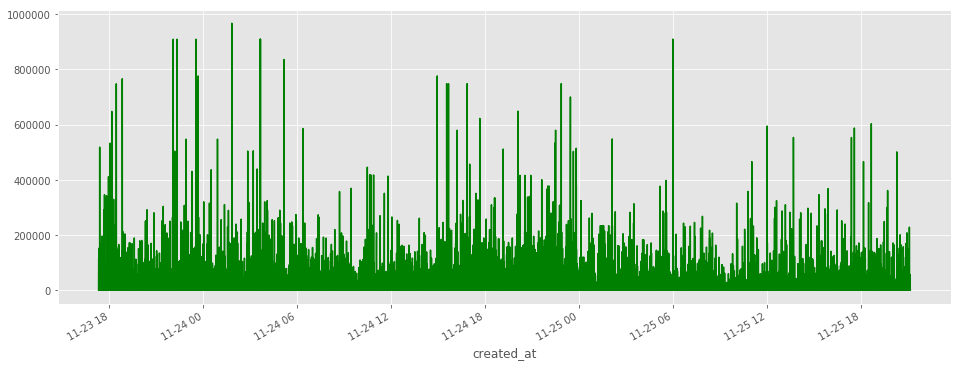

In [19]:
# Creating a Time Series chart showing Number of Likes vs Created_at (Date)

tfav = pd.Series(data=tweets['Likes'].values, index=tweets['created_at'])
tfav.plot(figsize=(16,6), color='g')

- The tweet with the most likes was created on the 24th of November, 2018

In [20]:
# Table showing Location for top 15 tweets in terms of number of Likes

top_likes=pd.DataFrame(tweets.nlargest(15, 'Likes'))
top_likes.head()

,text,lang,word_count,Location,country,id,created_at,Source,Likes,RT
5437,"Homenagem ao STAN LEE: ♫ ""O Criador de Heróis""...",pt,13,Mogi das Cruzes - SP,None,1066146790704128000,2018-11-24 01:49:37,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",967317,False
30688,RT @ComicBookNOW: Michigan State Marching Band...,en,15,"Houston, Texas",None,1066572201179209729,2018-11-25 06:00:03,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",909891,True
30684,RT @ComicBook: Why Bill Maher is wrong about S...,en,14,"Houston, Texas",None,1066572146678394881,2018-11-25 05:59:50,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",909889,True
6483,RT @ComicBookNOW: Kevin Smith Hadn't Seen Stan...,en,24,"Houston, Texas",None,1066174093672632321,2018-11-24 03:38:07,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",909567,True
6496,RT @ComicBookNOW: Kevin Smith Reacts To Bill M...,en,16,"Houston, Texas",None,1066174428055248896,2018-11-24 03:39:26,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",909566,True


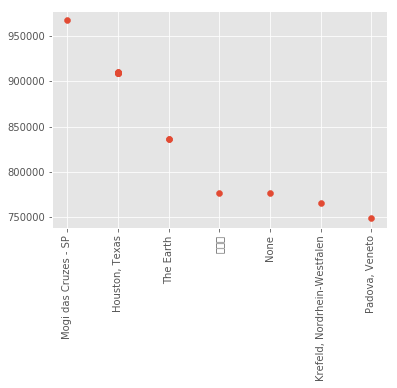

In [21]:
top_likes['Location'] = top_likes['Location'].astype('str') 

# Plotting location of top liked tweets
plt.scatter(top_likes['Location'],top_likes['Likes'].values)
plt.xticks(rotation=90)
plt.show()

- The tweet with the most likes was generated from a region called Mogi das Cruzes in the city of Sao Paulo, Brazil

In [22]:
# Obtain all possible sources:
sources = []
for source in tweets['Source']:
    if source not in sources:
        sources.append(source)

# We print a list displaying the sources:
print("Creation of content sources:")
for source in sources:
    print("* {}".format(source))

Creation of content sources:
* <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>
* <a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>
* <a href="http://twicca.r246.jp/" rel="nofollow">twicca</a>
* <a href="https://mobile.twitter.com" rel="nofollow">Twitter Lite</a>
* <a href="http://twitter.com/download/android" rel="nofollow">Twitter for Android</a>
* <a href="http://www.handmark.com" rel="nofollow">TweetCaster for iOS</a>
* <a href="http://twitter.com/#!/download/ipad" rel="nofollow">Twitter for iPad</a>
* <a href="https://buffer.com" rel="nofollow">Buffer</a>
* <a href="https://www.google.com/" rel="nofollow">Google</a>
* <a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>
* <a href="https://ifttt.com" rel="nofollow">IFTTT</a>
* <a href="http://publicize.wp.com/" rel="nofollow">WordPress.com</a>
* <a href="https://tapbots.com/software/tweetbot/mac" rel="nofollow">Tweetbot for Mac</a>
* <a href="http://w

In [23]:
# Using regex to extract the relevant information - eg. "Twitter for iPhone"
content_sources=[]
for source in tweets['Source']:
    result=re.search('(?<=">)(.*)(?=</a>)',source).group(1)
    content_sources.append(result)

content_sources[:5]

['Twitter for iPhone',
 'Twitter Web Client',
 'twicca',
 'Twitter Web Client',
 'Twitter for iPhone']

In [24]:
# Getting count of each source
from collections import Counter
print(Counter(content_sources))

Counter({'Twitter for Android': 12598, 'Twitter for iPhone': 12262, 'Twitter Web Client': 4729, 'Twitter Lite': 1299, 'Google': 1181, 'Twitter for iPad': 825, 'TweetDeck': 444, 'IFTTT': 354, 'Facebook': 327, 'Instagram': 268, 'WordPress.com': 230, 'dlvr.it': 206, 'Buffer': 181, 'Hootsuite Inc.': 177, 'BSPN twitter bots': 163, 'Paper.li': 122, 'twicca': 76, 'Tweetbot for iΟS': 55, 'CabronaGold-2': 44, 'Mobile Web (M2)': 39, 'Tumblr': 37, 'Crowdfire - Go Big': 35, 'TweetCaster for Android': 35, 'Hootsuite': 34, 'CL-Radio.com Tweets': 33, 'CabronaGold-2a': 29, 'Curious Cat': 27, 'Echofon': 25, 'Period Comics': 20, 'Tweetlogix': 19, 'Twibble.io': 18, 'SocialFlow': 16, 'Twitterrific for iOS': 12, 'Flamingo for Android': 12, 'Vincula atr': 12, 'app para tatuajes': 11, 'Plume\xa0for\xa0Android': 11, 'SocialOomph': 11, 'Media Studio': 11, 'a1Pie': 11, 'Cheap Bots, Done Quick!': 10, 'eClincher': 10, 'Postcron App': 9, 'PlayStation(R)4': 9, 'Goodreads': 9, 'Cabrona-2c': 9, 'We Got This Covered':

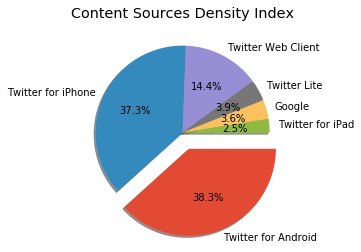

In [25]:
# Plotting top 6 sources - in terms of % distribution

values=[12598,12262,4729,1299,1181,825]
labels = ['Twitter for Android', 'Twitter for iPhone', 'Twitter Web Client', 'Twitter Lite', 'Google', 'Twitter for iPad']
explode = (0.2, 0, 0, 0, 0, 0)
plt.pie(values, labels=labels,explode=explode, autopct='%1.1f%%',counterclock=False, shadow=True)
plt.title('Content Sources Density Index')
plt.show()

- It is quite evident from the chart above that majority of the users tweeted using a **mobile device**, specifically an Android device. This was followed by an iphone

In [ ]:
# Plotting location of tweets on a basemap (world map)

plt.figure( figsize=(20,10), facecolor='k')
m = Basemap(projection='mill',resolution=None,llcrnrlat=-90,urcrnrlat=90,llcrnrlon=-180,urcrnrlon=180)
m.etopo()
xpt,ypt = m(np.array(tweets['place_lon']),np.array(tweets['place_lat']))
lon,lat = m(xpt,ypt,inverse=True)
m.plot(xpt,ypt,'ro',markersize=np.sqrt(5)) 
plt.title('Repartition on the globe', bbox={'facecolor':'0.8', 'pad':3})
plt.show()

In [ ]:
# Alternatively

# # plot the blank world map
# my_map = Basemap(projection='merc', lat_0=50, lon_0=-100,
#                      resolution = 'h', area_thresh = 5000.0,
#                      llcrnrlon=-140, llcrnrlat=-55,
#                      urcrnrlon=160, urcrnrlat=70)
# # set resolution='h' for high quality
 
# # draw elements onto the world map
# my_map.drawcountries()
# #my_map.drawstates()
# my_map.drawcoastlines(antialiased=False, linewidth=0.005)
 
# # add coordinates as red dots
# longs = list(tweets.loc[(tweets.long != None)].long)
# latts = list(tweets.loc[tweets.latt != None].latt)
# x, y = my_map(longs, latts)
# my_map.plot(x, y, 'ro', markersize=6, alpha=0.5)
 
# plt.show()

### SENTIMENT ANALYSIS

Cleaning / Pre-processing

In [26]:
#importing NLTK for preprocessing tweets

import nltk
from nltk.corpus import stopwords

stop = stopwords.words('english')

In [28]:
# 10 most common words before preprocessising - first converting to lowercase to avoid duplication of words
y=[x.lower() for x in tweets['text']]

In [29]:
freq = pd.Series(' '.join(y).split()).value_counts()[:10]
freq

rt       28411
stan     26458
lee      20572
a        15758
and      12681
in       10995
the       7931
up        7225
mural     6803
south     6647
dtype: int64

In [27]:
# Function to preprocess dataset
def preprocess(text_data):
    preprocessed_text=[]
    for text in text_data:
        #regext to remove RT retweets
        text=re.sub('RT'," ",text)
        #regex to remove punctuations,hashtags,@usermentions,URLs and convert to lowercase
        text=re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",text).lower()
        #regex to remove numbers
        text=re.sub("\d+", " ", text)
        preprocessed_text.append(text)
    return preprocessed_text

In [30]:
preprocessed_set=preprocess(tweets['text'])

In [31]:
# Removing stop words
processed_text = pd.Series(preprocessed_set)
tweets['text'] = processed_text.apply(lambda x: " ".join(x for x in x.split() if x not in stop))
tweets['text'].head(4)

0    stan lee course great friend hero initiative b...
1    stan lee memorial mural popped south los angel...
2    marvel studios chief kevin feige describes fin...
3    new stan let flop come onnnn rt u love real qu...
Name: text, dtype: object

In [32]:
# Common words after general/basic preprocessing
freq = pd.Series(' '.join(tweets['text']).split()).value_counts()[:10]
freq

stan       28840
lee        26241
th          7107
mural       6806
south       6647
andrews     6644
popped      6639
los         6328
really      5754
marvel      5688
dtype: int64

In [33]:
# common words removal as they dont help much with the analysis
freq = list(freq.index)
tweets['text'] = tweets['text'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))

In [34]:
# displaying rare words
freq = pd.Series(' '.join(tweets['text']).split()).value_counts()[-10:]
freq

sister             1
conque             1
moviebucketlist    1
somethings         1
toxico             1
yaaa               1
disn               1
missyoualready     1
toisin             1
sushi              1
dtype: int64

In [35]:
# removing rare words as they dont help much with the analysis
freq = list(freq.index)
tweets['text'] = tweets['text'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))

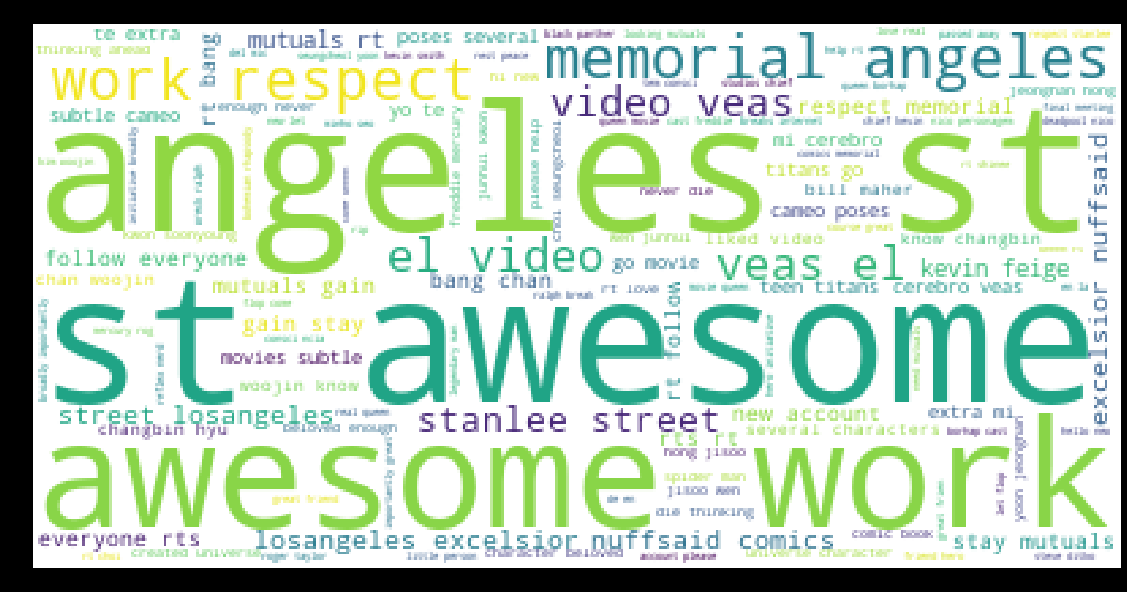

In [36]:
# Creating WordCloud of 'new' words - significant in analysis (size of words show significance and freq count)
def wordcloud(tweets,col):
    stopwords = set(STOPWORDS)
    wordcloud = WordCloud(background_color="white",stopwords=stopwords).generate(" ".join([i for i in tweets[col]]))
    plt.figure( figsize=(20,10), facecolor='k')
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title("Stan Lee Datascience")
wordcloud(tweets,'text') 

In [37]:
# function to perform tokenization of tweets
def tokenizeit(text_data):
    tokenized_text=[]
    for text in text_data:
        #tokenize the text
        tokenized=nltk.word_tokenize(text)
        #remove stop words
        tokenized_text.append(" ".join(list(x for x in tokenized if x not in stop)))
    return tokenized_text

In [38]:
tokenized_tweets=tokenizeit(tweets['text'])
tokenized_tweets[:5]

['course great friend hero initiative broadly importantly great frien',
 'memorial angeles st awesome work respect',
 'studios chief kevin feige describes final meeting',
 'new let flop come onnnn rt u love real queen movie queen borhap cast freddie mercury rog',
 'studios chief kevin feige describes final meeting']

In [39]:
# Lemmatization - bringing words to its root form (reduces overall count of words)
from nltk.stem import wordnet
from nltk.stem import WordNetLemmatizer
word_lem=WordNetLemmatizer()
tweets_cleaned = [" ".join(word_lem.lemmatize(token) for token in sentence.split(" ")) for sentence in tokenized_tweets]
tweets_cleaned[:5]

['course great friend hero initiative broadly importantly great frien',
 'memorial angeles st awesome work respect',
 'studio chief kevin feige describes final meeting',
 'new let flop come onnnn rt u love real queen movie queen borhap cast freddie mercury rog',
 'studio chief kevin feige describes final meeting']

Stemming and Lemmatization both generate the root form of the inflected words. The difference is that stem might not be an actual word whereas, lemma is an actual language word. (Stemming not used here)

In [40]:
processed_tweets = pd.Series(tweets_cleaned)

# sentiment analysis again using Textblob
tweets['sentiment'] = processed_tweets.apply(lambda x: tb(x).sentiment[0] )
tweets[['text','sentiment']].head(5)

,text,sentiment
0,course great friend hero initiative broadly im...,0.800000
1,memorial angeles st awesome work respect,1.000000
2,studios chief kevin feige describes final meeting,0.000000
3,new let flop come onnnn rt u love real queen m...,0.278788
4,studios chief kevin feige describes final meeting,0.000000


In [41]:
# We construct lists with classified tweets:

pos_tweets = [ tweet for index, tweet in enumerate(tweets['text']) if tweets['sentiment'][index] > 0]
neu_tweets = [ tweet for index, tweet in enumerate(tweets['text']) if tweets['sentiment'][index] == 0]
neg_tweets = [ tweet for index, tweet in enumerate(tweets['text']) if tweets['sentiment'][index] < 0]

In [42]:
# We print the percentages:

print("Percentage of positive tweets: {}%".format(len(pos_tweets)*100/len(tweets['text'])))
print("Percentage of neutral tweets: {}%".format(len(neu_tweets)*100/len(tweets['text'])))
print("Percentage de negative tweets: {}%".format(len(neg_tweets)*100/len(tweets['text'])))

Percentage of positive tweets: 47.117063059131574%
Percentage of neutral tweets: 45.58422430722234%
Percentage de negative tweets: 7.298712633646083%


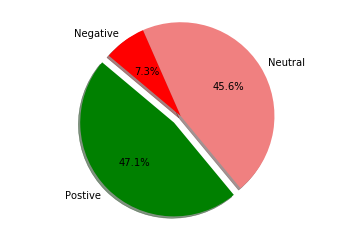

In [43]:
# Data to plot
labels = 'Postive', 'Neutral', 'Negative'
sizes = [(len(pos_tweets)/len(tweets['text'])),(len(neu_tweets)/len(tweets['text'])),(len(neg_tweets)/len(tweets['text']))]
colors = ['green', 'lightcoral', 'red']
explode = (0.1, 0, 0)  # explode 1st slice
 
# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
 
plt.axis('equal')
plt.show()

- We can see above that the majority of the tweets collected were of a positive or neutral sentiment. Only a small % of the tweets reflected negative sentiments

In [ ]:
# rounding sentiments for creating the model
for col in tweets.columns:
    tweets['sentiment'][tweets['sentiment'] < 0] = -1
    tweets['sentiment'][tweets['sentiment'] > 0] = 1

Multiclass classification - 3 classes (-1,0,1)

In [45]:
tweets['sentiment'] = tweets['sentiment'].astype(int)

In [47]:
tweets[['text','sentiment']].head(5)

,text,sentiment
0,course great friend hero initiative broadly im...,1
1,memorial angeles st awesome work respect,1
2,studios chief kevin feige describes final meeting,0
3,new let flop come onnnn rt u love real queen m...,1
4,studios chief kevin feige describes final meeting,0


## Splitting Train - Test data

In [48]:
X = tweets['text']  
y = tweets['sentiment'] 

In [49]:
from sklearn.model_selection import train_test_split  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)  

#### Using CountVectorizer to get bag of words features

In [52]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer =CountVectorizer(stop_words='english')
text=vectorizer.fit_transform(X_train)
print(vectorizer.vocabulary_)

{'rip': 10568, 'stanlee': 11734, 'heroes': 5464, 'cheesy': 1933, 'man': 7445, 'named': 8271, 'seunghwan': 11150, 'yes': 13761, 'proud': 9824, 'memorial': 7724, 'angeles': 465, 'st': 11707, 'awesome': 915, 'work': 13625, 'respect': 10394, 'maher': 7392, 'wrong': 13674, 'comic': 2221, 'books': 1356, 'boi': 1325, 'bob': 1312, 'street': 11862, 'losangeles': 7252, 'excelsior': 4100, 'nuffsaid': 8625, 'comics': 2235, 'richard': 10529, 'traz': 12709, 'na': 8241, 'sexta': 11165, 'feira': 4368, 'spider': 11648, 'por': 9540, 'que': 9950, 'gostei': 5035, 'muito': 8162, 'desse': 3107, 'jogo': 6414, 'legal': 6951, 'thelastofusnoeigames': 12385, 'avenger': 885, 'movie': 8115, 'captain': 1697, 'america': 412, 'iron': 6192, 'gonna': 5011, 'die': 3209, 'burial': 1557, 'scene': 10906, 'grave': 5109, 'rendimos': 10330, 'homenaje': 5588, 'al': 291, 'padre': 8951, 'superh': 11997, 'roes': 10646, 'esta': 3990, 'galer': 4772, 'personajes': 9263, 'creados': 2583, 'nighthawk': 8479, 'adventure': 187, 'cameo': 

In [53]:
vectorizer.transform(X_test).toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [56]:
df=pd.DataFrame(vectorizer.fit_transform(X_train).toarray(),columns=vectorizer.get_feature_names())
df.head()

,aaa,aaaa,aaaaa,aaaaaa,aaaaaaaaa,aaaaaaaaaaaaaaaaaaaa,aaaah,aaaauugghhh,aad,aakashaggarwal,...,zootopia,zosta,zov,zte,zu,zuar,zuk,zulu,zuma,zya
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [57]:
test_df=pd.DataFrame(vectorizer.transform(X_test).toarray(),columns=vectorizer.get_feature_names())
test_df.head()

,aaa,aaaa,aaaaa,aaaaaa,aaaaaaaaa,aaaaaaaaaaaaaaaaaaaa,aaaah,aaaauugghhh,aad,aakashaggarwal,...,zootopia,zosta,zov,zte,zu,zuar,zuk,zulu,zuma,zya
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [58]:
x_train=df
x_test=test_df

### Using Multinomial Naïve Bayes classifier for the purpose of classification - Good for discrete multiclass target variables

In [60]:
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB
algorithm_a=MultinomialNB()
algorithm_a.fit(x_train,y_train)
output=algorithm_a.predict(x_test)

In [61]:
metrics.accuracy_score(y_test,output)

0.8692213282421928

In [62]:
metrics.confusion_matrix(y_test,output)

array([[ 448,   12,   57],
       [ 120, 2639,  564],
       [  72,  134, 3287]], dtype=int64)

### Evaluate additional models

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

Logistic Regression

In [ ]:
algorithm_lr=LogisticRegression(solver='lbfgs', multi_class='multinomial')
algorithm_lr.fit(x_train,y_train)
output_lr=algorithm_lr.predict(x_test)

# model accuracy   
metrics.accuracy_score(y_test,output_lr)
  
# creating a confusion matrix 
metrics.confusion_matrix(y_test,output_lr)

Support Vector Machine

In [ ]:
svm_model_linear = SVC(kernel = 'linear', C = 1).fit(x_train,y_train) 
svm_predictions = svm_model_linear.predict(x_test) 
  
# model accuracy   
metrics.accuracy_score(y_test,svm_predictions)
  
# creating a confusion matrix 
metrics.confusion_matrix(y_test,svm_predictions)

Random Forrest

In [ ]:
rforrest_model = RandomForestClassifier(n_estimators=100, max_depth=2.fit(x_train,y_train) 
rforrest_predictions = dtree_model.predict(x_test) 
                                        
# model accuracy   
metrics.accuracy_score(y_test,rforrest_predictions)
  
# creating a confusion matrix 
metrics.confusion_matrix(y_test,rforrest_predictions)

We will benchmark the following four models:
- Logistic Regression
- (Multinomial) Naive Bayes
- Linear Support Vector Machine
- Random Forest

In [ ]:
from sklearn.model_selection import cross_val_score
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB()
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()